## Evaluating Reasoning Module

In [1]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, dirname

In [2]:
ANNOTATED_VIDEOS_PATH = '/Users/rlopez/PTG/tim-reasoning/tim_reasoning/resource/annotated_videos'

def evaluate_reasoning(inputs_by_step):
    performances = []
    print('Accuracy')
    for step_id in inputs_by_step.keys():
        performance = evaluate_reasoning_step(inputs_by_step, step_id)
        print(f'Step: {step_id}: {performance}')
        performances.append(performance)
    
    total = sum(performances)/len(performances)
    print('Total:', total)


def evaluate_reasoning_step(inputs_by_step, current_step_id, show_output=False):
    actions_in_step = inputs_by_step[current_step_id]
    num_actions = float(len(actions_in_step))
    detected_steps = [x['output'] for x in actions_in_step]
    performance = detected_steps.count(current_step_id) / num_actions
    
    if show_output:
        print('Predicted Steps:', detected_steps)
    
    return performance

        
def rank_actions(inputs_by_step, step_id, top=100):
    actions_in_step = inputs_by_step[step_id]
    all_actions = {}
    
    for actions_data in actions_in_step:
        for action_label, action_proba in actions_data['detected_actions']:
            if action_label not in all_actions:
                all_actions[action_label] = 0
            all_actions[action_label] += action_proba
            
    num_inputs = len(actions_in_step)
    all_actions = {k: v/num_inputs for k, v in all_actions.items()}
    sorted_actions = sorted(all_actions.items(), key=lambda x: x[1], reverse=True)
    print(f'Total inputs: {num_inputs}')
    print('Ranking of Actions:')
    for action_label, action_proba in sorted_actions[:top]:
        print(f'{action_label}: {action_proba}')


def calculate_probabilities(inputs_by_step, step_id, top=100):
    actions_in_step = inputs_by_step[step_id]
    all_actions = {}
    num_actions = 0.0
    for actions_data in actions_in_step:
        for action_label, _ in actions_data['detected_actions']:
            if action_label not in all_actions:
                all_actions[action_label] = 0
            all_actions[action_label] += 1
            num_actions += 1
    
    all_actions = {k: v/num_actions for k, v in all_actions.items()}
    sorted_actions = sorted(all_actions.items(), key=lambda x: x[1], reverse=True)
    
    print(f'Total actions: {int(num_actions)}')
    print('Ranking of Probabilities:')
    for action_label, action_proba in sorted_actions[:top]:
        print(f'{action_label}: {action_proba}')


def create_matrix(recipe_id, normalize=True):
    annotations = pd.read_csv(join(ANNOTATED_VIDEOS_PATH, f'recipe_{recipe_id}.csv'), keep_default_na=False)
    annotations = annotations[annotations['video_id'] != 'coffee-test-2']  # For testing
    annotations = annotations[annotations['step_id'] != 'NA']
    no_action_label = 'no action'
    annotations['narration'] = annotations['narration'].replace(['NA'], no_action_label)
    unique_steps = {s: i for i, s in enumerate(annotations['step_id'].unique())}
    unique_actions = {a: i for i, a in enumerate(annotations['narration'].unique())}

    if no_action_label not in unique_actions:
        unique_actions[no_action_label] = len(unique_actions)

    matrix = np.zeros((len(unique_steps), len(unique_actions)))

    for _, row in annotations.iterrows():
        action_index = unique_actions[row['narration']]
        step_index = unique_steps[row['step_id']]
        duration = row['stop_sec'] - row['start_sec']

        matrix[step_index][action_index] += duration

    if normalize:
        row_sums = matrix.sum(axis=1)
        matrix = matrix / row_sums[:, np.newaxis]

    return {'indexes': unique_actions, 'matrix': matrix}

def create_matrix_dict(recipe_id, normalize=True):
    # TODO: Add "no action" as a step
    annotations = pd.read_csv(join(ANNOTATED_VIDEOS_PATH, f'recipe_{recipe_id}.csv'), keep_default_na=False)
    annotations = annotations[annotations['step_id'] != 'NA']
    annotations['narration'] = annotations['narration'].replace(['NA'], 'no action')
    unique_steps = annotations['step_id'].unique()
    unique_actions = annotations['narration'].unique()
    matrix = {}
    
    for step in unique_steps:
        matrix[step] = {}
        for action in unique_actions:
            matrix[step][action] = 0
        # Add the 'no action' label
        if 'no action' not in matrix[step]:
            matrix[step]['no action'] = 0

    for index, row in annotations.iterrows():
        action = row['narration']
        step = row['step_id']
        duration = row['stop_sec'] - row['start_sec']
        matrix[step][action] += duration

    if normalize:
        for step, actions in matrix.items():
            total_duration = float(sum([x for x in matrix[step].values()]))
            matrix[step] = {k: v/total_duration for k, v in matrix[step].items()}
            
    return matrix

In [3]:
recipe_id = 'pinwheels'

with open(f'/Users/rlopez/PTG/tim-reasoning/scripts/evaluations/resource/recipe_{recipe_id}.pickle', 'rb') as f:
    inputs_by_step = pickle.load(f)

with open(f'/Users/rlopez/PTG/tim-reasoning/tim_reasoning/resource/mit_recipes/recipe_{recipe_id}.json') as fin:
    recipe_steps = {str(i): v for i, v in enumerate (json.load(fin)['instructions'], 1)}

### Overall Results

In [ ]:
evaluate_reasoning(inputs_by_step)

### Individual Results

In [5]:
step_id = '1'
print(f'Step {step_id}: "{recipe_steps[step_id]}"')

Step 1: "Place tortilla on cutting board."


In [6]:
accuracy = evaluate_reasoning_step(inputs_by_step, step_id, True)

Predicted Steps: ['1', '1', '1', '1', '1']


In [7]:
rank_actions(inputs_by_step, step_id)
print('')
calculate_probabilities(inputs_by_step, step_id)

Total inputs: 5
Ranking of Actions:
wrap wrap: 0.5836822163313627
put tortilla: 0.11426806543022394
wash knife cloth: 0.10976165067404509
apply spreads: 0.10077090971171856
scoop spreads: 0.04119620025157929
take knife: 0.014252858725376428
no action: 0.010869679693132638
put wrap plate: 0.007393367169424891
take wire: 0.005728509183973074
cut wrap wire: 0.004162352532148361
move wrap: 0.0029128803173080085
take jar: 0.0028042993508279324
insert wire: 0.0013466126401908696
put knife: 0.0004890007840003818
take cloth: 0.00018306731508346274
cut wrap knife: 0.00017834387472248636

Total actions: 80
Ranking of Probabilities:
put tortilla: 0.0625
wash knife cloth: 0.0625
apply spreads: 0.0625
scoop spreads: 0.0625
put wrap plate: 0.0625
take knife: 0.0625
no action: 0.0625
move wrap: 0.0625
cut wrap wire: 0.0625
take wire: 0.0625
wrap wrap: 0.0625
take jar: 0.0625
put knife: 0.0625
insert wire: 0.0625
take cloth: 0.0625
cut wrap knife: 0.0625


{'take tortilla': 0, 'put tortilla': 1, 'take knife': 2, 'take cloth': 3, 'take jar': 4, 'scoop spreads': 5, 'apply spreads': 6, 'wash knife cloth': 7, 'put knife': 8, 'move wrap': 9, 'wrap wrap': 10, 'take wire': 11, 'insert wire': 12, 'cut wrap knife': 13, 'cut wrap wire': 14, 'put wire': 15, 'put wrap plate': 16, 'take wrap': 17, 'take bag': 18, 'open bag': 19, 'open jar': 20, 'no action': 21}


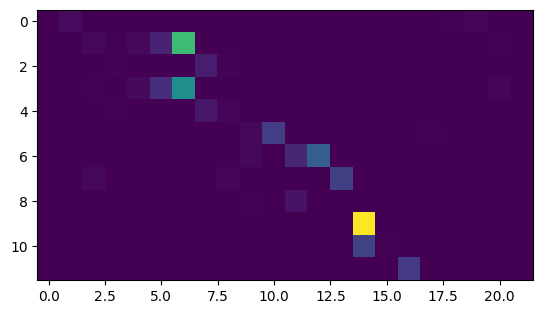

In [8]:
matrix = create_matrix(recipe_id, False)['matrix']
indexes = create_matrix(recipe_id)['indexes']
print(indexes)
plt.imshow(matrix,)

In [9]:
step = 1
[(a, matrix[step][i]) for a, i in indexes.items()]

[('take tortilla', 0.0),
 ('put tortilla', 0.0),
 ('take knife', 9.0),
 ('take cloth', 2.0),
 ('take jar', 11.0),
 ('scoop spreads', 41.0),
 ('apply spreads', 296.0),
 ('wash knife cloth', 0.0),
 ('put knife', 0.0),
 ('move wrap', 0.0),
 ('wrap wrap', 0.0),
 ('take wire', 0.0),
 ('insert wire', 0.0),
 ('cut wrap knife', 0.0),
 ('cut wrap wire', 0.0),
 ('put wire', 0.0),
 ('put wrap plate', 0.0),
 ('take wrap', 0.0),
 ('take bag', 0.0),
 ('open bag', 0.0),
 ('open jar', 5.0),
 ('no action', 0.0)]

In [10]:
matrix_dict = create_matrix_dict(recipe_id)
matrix_dict['8']

{'take tortilla': 0.0,
 'put tortilla': 0.0,
 'take knife': 0.10101010101010101,
 'take cloth': 0.0,
 'take jar': 0.0,
 'scoop spreads': 0.0,
 'apply spreads': 0.0,
 'wash knife cloth': 0.0,
 'put knife': 0.08080808080808081,
 'move wrap': 0.0,
 'wrap wrap': 0.0,
 'take wire': 0.0,
 'insert wire': 0.0,
 'cut wrap knife': 0.8181818181818182,
 'cut wrap wire': 0.0,
 'put wire': 0.0,
 'put wrap plate': 0.0,
 'take wrap': 0.0,
 'take bag': 0.0,
 'open bag': 0.0,
 'open jar': 0.0,
 'no action': 0.0}

In [11]:
inputs_by_step[step_id]

[{'time': 20.730143785476685,
  'detected_actions': [('put tortilla', 0.543027400970459),
   ('wash knife cloth', 0.24217437207698822),
   ('apply spreads', 0.06834840029478073),
   ('scoop spreads', 0.06427710503339767),
   ('put wrap plate', 0.022315338253974915),
   ('take knife', 0.011227279901504517),
   ('no action', 0.010732024908065796),
   ('move wrap', 0.009000993333756924),
   ('cut wrap wire', 0.0076096393167972565),
   ('take wire', 0.006415889132767916),
   ('wrap wrap', 0.0057398732751607895),
   ('take jar', 0.00534234382212162),
   ('put knife', 0.0016027139499783516),
   ('insert wire', 0.0012225662358105183),
   ('take cloth', 0.0005582384183071554),
   ('cut wrap knife', 0.0004058251215610653)],
  'output': '1'},
 {'time': 21.820941925048828,
  'detected_actions': [('wrap wrap', 0.6166084408760071),
   ('apply spreads', 0.18682706356048584),
   ('wash knife cloth', 0.1595708578824997),
   ('scoop spreads', 0.009613214060664177),
   ('put tortilla', 0.006959469988942